In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, precision_recall_curve, recall_score, accuracy_score
#sns.set_palette(palette)

In [2]:
file = "Human_activity_recognition.csv"
df = pd.read_csv(file)

In [3]:
Y = df.Activity
X = df.drop('Activity',axis=1)

In [4]:
df.dtypes.tail()

angle(tBodyGyroJerkMean,gravityMean)    float64
angle(X,gravityMean)                    float64
angle(Y,gravityMean)                    float64
angle(Z,gravityMean)                    float64
Activity                                 object
dtype: object

In [5]:
df.iloc[:,:-1].min().value_counts()

-1.0    561
dtype: int64

In [6]:
df.iloc[:,:-1].max().value_counts()

1.0    561
dtype: int64

In [7]:
df.Activity.value_counts()

LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: Activity, dtype: int64

# This is a balanced dataset, so what is the best type of error metric to use?

In [8]:
from sklearn.preprocessing import LabelEncoder

In [9]:
le = LabelEncoder()
df['Activity_transformed'] = le.fit_transform(df.Activity)

In [70]:
#This is the mapping between activity and labels
label_mapping = df.groupby('Activity')['Activity_transformed'].mean()

# Let's calculate the correlation between the independent variables
Create a histogram of the correlation values
identify the most correlated

In [10]:
corr_values = X.corr()
tril_index = np.tril_indices_from(corr_values)

corr_array = np.array(corr_values)
corr_array[tril_index] = np.nan

In [12]:
corr_df = pd.DataFrame(corr_array,columns = corr_values.columns,index = corr_values.index)


In [13]:
corr_df = corr_df.stack().to_frame().reset_index().rename(columns = {'level_0':'feature1',
                                                                    'level_1': 'feature 2',
                                                                    0:'correlation'})
                

In [14]:
corr_df['abs_corr'] = abs(corr_df['correlation'])

In [17]:
corr_df.sort_values('abs_corr',ascending=False).head(5)

,feature1,feature 2,correlation,abs_corr
93902,tBodyAccMag-sma(),tGravityAccMag-sma(),1.0,1.0
96017,tBodyAccMag-arCoeff()3,tGravityAccMag-arCoeff()3,1.0,1.0
94964,tBodyAccMag-entropy(),tGravityAccMag-entropy(),1.0,1.0
96706,tGravityAccMag-mean(),tGravityAccMag-sma(),1.0,1.0
93546,tBodyAccMag-min(),tGravityAccMag-min(),1.0,1.0


array([[<AxesSubplot:title={'center':'abs_corr'}>]], dtype=object)

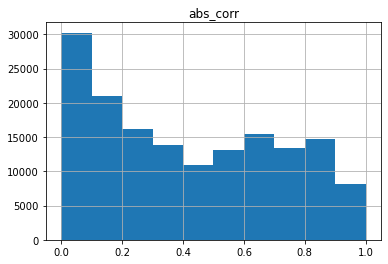

In [20]:
corr_df.hist('abs_corr')

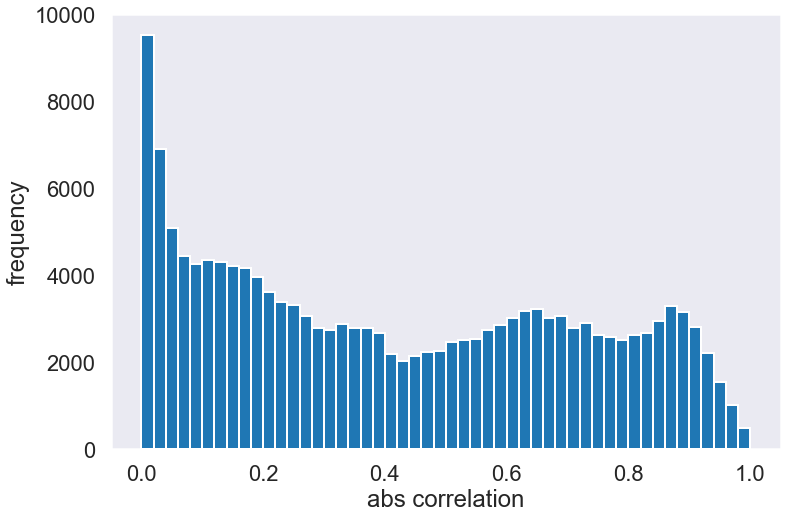

In [29]:
sns.set_context('poster')
sns.set_style('dark')

ax=corr_df['abs_corr'].hist(bins=50,figsize=(12,8),grid=False)
ax.set(xlabel='abs correlation',ylabel = 'frequency')
plt.show()

# Now split the data into train and test datasets. use Stratified ShuffleSplit
compare the ratio of classes in the train and test split

In [38]:
from sklearn.model_selection import StratifiedShuffleSplit

In [96]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=1)
sss.get_n_splits(X,Y)

1

In [97]:
Y = df['Activity_transformed']

In [99]:
#doing stratified shufflesplit manually
train_idx, test_idx = next(sss.split(df[X.columns],df['Activity_transformed']))

X_train = df.loc[train_idx,X.columns]
y_train = df.loc[train_idx,['Activity_transformed']]
#so here we create the x and y for one instance of the sss

x_test = df.loc[test_idx,X.columns]
y_test = df.loc[test_idx,['Activity_transformed']]



In [110]:
y_train.shape

(7209, 1)

In [108]:
np.array(y_train).reshape(-1).shape

(7209,)

In [113]:
y_train.value_counts(normalize=True)


Activity_transformed
0                       0.188792
2                       0.185046
1                       0.172562
3                       0.167152
5                       0.149951
4                       0.136496
dtype: float64

# OK now we're setting up a logistic regression

In [115]:
lr = LogisticRegression(solver='liblinear').fit(X_train,y_train)

/Users/jacoblourie/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [123]:
preds_basic = lr.predict(x_test)
accuracy_score(preds_basic,y_test)

0.9812297734627832

In [124]:
from sklearn.linear_model import LogisticRegressionCV
#importing the ability to do the cross validation automatically

lr_l1 = LogisticRegressionCV(Cs=10,cv=4,penalty='l1', solver = 'liblinear').fit(X_train,y_train)

/Users/jacoblourie/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [125]:
lr_l2 = LogisticRegressionCV(Cs = 10, cv=4, penalty ='l2',solver = 'liblinear').fit(X_train,y_train)

/Users/jacoblourie/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [162]:
coefficients = list()

coeff_labels = ['lr','lr_l1', 'lr_l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels = [[lab],[0,1,2,3,4,5]],
                               codes = [[0,0,0,0,0,0],[0,1,2,3,4,5]])
    coefficients.append(pd.DataFrame(coeffs.T,columns=coeff_label))
    
coefficients1 = pd.concat(coefficients,axis=1)

coefficients1

lr                                                       lr_l1  \
            0         1         2         3         4         5         0   
0   -0.070718 -0.514241  0.286969 -0.153108  0.682050 -0.047802  0.000000   
1    0.000328 -0.279924  0.166647  0.032470  0.156540 -0.256272  0.000000   
2    0.031315  0.012980  0.365968  0.077230  0.281404 -0.481036  0.000000   
3   -0.001248 -0.708525 -0.356248 -0.676203  0.254349  0.652690  0.043239   
4   -0.056083 -0.021216 -0.455041  0.232579 -0.487521  0.211378  0.000000   
..        ...       ...       ...       ...       ...       ...       ...   
556  0.014920 -0.774613  0.689848 -0.135773  0.500988 -0.460556  0.000000   
557  0.031278 -0.341497  0.376489 -0.104372 -0.035859  0.149334 -0.000287   
558  1.593736 -2.248973 -0.984073 -0.273113 -0.704650  0.509013  3.660422   
559 -0.373650 -0.903142  1.788551 -0.225611 -0.243317  0.871769 -0.483285   
560 -0.195211 -0.303237  0.411433  0.001179 -0.064911  0.462834  0.000000   

                                                          lr_l2            \
            1         2         3         4         5         0         1   
0    0.000000  0.000000 -0.962380  3.676413  0.000000 -0.061675 -0.831766   
1    0.000000  0.000000  0.000000  1.724460  0.000000  0.000598 -0.595863   
2    0.000000  0.000000  0.000000  1.995468 -0.443000  0.026205 -0.036322   
3   -1.580975 -0.554022 -1.514313  0.392369  1.243147 -0.003629 -1.058347   
4    0.000000 -1.002687  0.180949 -0.957142  0.000000 -0.053460  0.019795   
..        ...       ...       ...       ...       ...       ...       ...   
556 -0.776819  0.680845 -0.383420  0.915912 -0.975524  0.026317 -0.834897   
557 -0.762902  0.855470 -0.141583  0.232144  0.670919  0.028385 -0.487756   
558 -6.262775 -0.650524  0.000000 -0.945339  0.675910  1.354723 -3.373555   
559  0.000000  0.000000  0.000000  0.300221  2.086942 -0.336830 -0.713086   
560  0.000000  0.000000  0.000000  0.155690  0.906797 -0.175408 -0.256874   

                                             
            2         3         4         5  
0    0.696995 -0.197083  0.931468  0.299820  
1    1.085419  0.049346  0.203627 -1.044852  
2    1.608813  0.116033  0.386148 -2.089345  
3   -0.933259 -0.864647  0.265125  2.634020  
4   -0.900120  0.329794 -0.611643  0.749521  
..        ...       ...       ...       ...  
556  0.874572 -0.186538  0.594263 -1.560684  
557  1.061261 -0.140195  0.008806  0.519264  
558 -2.064415 -0.332159 -0.920549  1.986796  
559  3.572697 -0.318736 -0.315958  3.546083  
560  0.707507 -0.017888 -0.081027  1.381036  

[561 rows x 18 columns]

# Note that lr_l1 has a lot of 0s

In [176]:
#quickly compare accuracy scores.
acc_dict = {}
for label, mod in zip(coeff_labels,coeff_models):
    acc_dict[label] = accuracy_score(mod.predict(x_test),y_test)

pd.Series(acc_dict).to_frame().rename(columns = {0:'accuracy'})

,accuracy
lr,0.981230
lr_l1,0.982848
lr_l2,0.983172


(3, 2)
(6,)


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

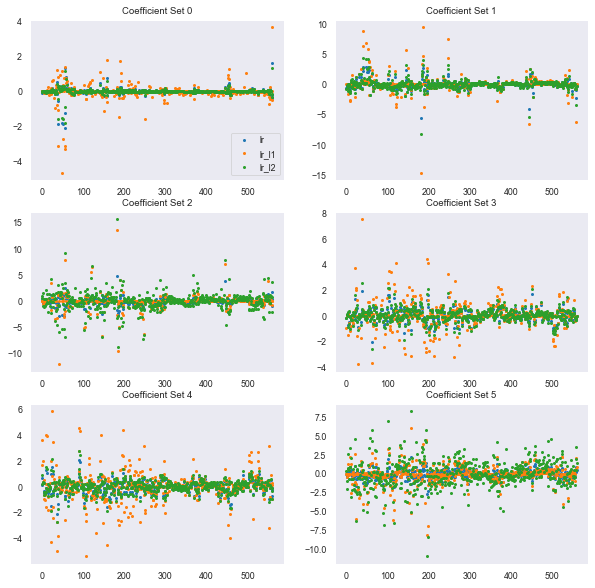

In [190]:
sns.set_context('paper')
fig, axList = plt.subplots(nrows =3, ncols=2)

axList = axList.flatten()
fig.set_size_inches(10,10)

for loc, ax in enumerate(axList):
    data = coefficients1.xs(loc,level = 1 , axis = 1) #take loc=1 to loc =6 at level 1 (coefficient level)
    data.plot(marker = 'o', ls = '',ms=2.0, ax = ax,legend = False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title = 'Coefficient Set '+str(loc))
    
plt.tight_layout

# predicting

In [195]:
y_pred = list()
y_prob = list()

coeff_labels = ['lr','l1','l2']
coeff_models = [lr,lr_l1,lr_l2]

for lab, mod in zip(coeff_labels,coeff_models):
    y_pred.append(pd.Series(mod.predict(x_test),name = lab))
    coeff_label = pd.MultiIndex(levels = [[lab],[0,1,2,3,4,5]],
                               codes = [[0,0,0,0,0,0],[0,1,2,3,4,5]])
    
    y_prob.append(pd.DataFrame(mod.predict_proba(x_test),columns = coeff_label))
    
y_pred =pd.concat(y_pred,axis=1)
y_prob =pd.concat(y_prob,axis=1)

In [232]:
y_pred_cor = y_pred.corr()
y_pred_cor

#corr_df = pd.DataFrame(y_pred_array).stack().to_frame().reset_index()#.rename(columns = ['model 1','model 2','correlation'])

,lr,l1,l2
lr,1.000000,0.998587,0.998702
l1,0.998587,1.000000,0.998758
l2,0.998702,0.998758,1.000000


# calculate the following metrics
accuracy

precision

recall

fscore

confusion matrix

In [265]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

In [248]:
y_pred['lr']

0       3
1       0
2       1
3       3
4       1
       ..
3085    1
3086    4
3087    2
3088    1
3089    5
Name: lr, Length: 3090, dtype: int64

In [261]:
precision = fscore(y_test, y_pred['lr'],average='weighted')
precision

(0.9814932989676406, 0.9812297734627832, 0.9812115426125764, None)

In [269]:
metrics = list()
cm = dict()

for lab in coeff_labels:
    precision, recall, fscore, _ = score(y_test, y_pred[lab],average = 'weighted')

    accuracy = accuracy_score(y_test,y_pred[lab])
    
    auc = roc_auc_score(label_binarize(y_test,classes = [0,1,2,3,4,5]),
                y_prob[lab],
                average = 'weighted')
    
    cm[lab] = confusion_matrix(y_test,y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision,'recall':recall,
                             'fscore':fscore, 'accuracy':accuracy,
                             'auc':auc},
                             name = lab))
    
metrics_db = pd.concat(metrics,axis=1)


In [270]:
metrics_db

,lr,l1,l2
precision,0.981493,0.983005,0.983268
recall,0.981230,0.982848,0.983172
fscore,0.981212,0.982840,0.983152
accuracy,0.981230,0.982848,0.983172
auc,0.999004,0.999163,0.999164


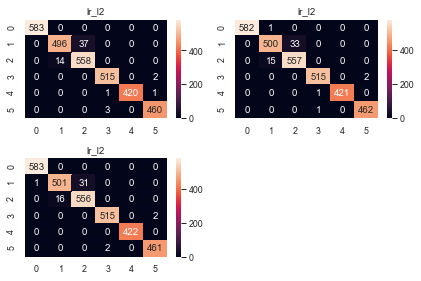

In [275]:
fig, axList = plt.subplots(nrows=2,ncols=2)
axList = axList.flatten()

axList[-1].axis('off')

for ax,lab in zip(axList[:-1],coeff_labels):
    sns.heatmap(cm[lab],ax=ax,annot=True,fmt='d');
    ax.set(title=label);

plt.tight_layout()